In [1]:
# Importing the basics
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from scipy.stats import binom
from scipy.io import savemat
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


TEST_PROPORTION = 0.05
VAL_PROPORTION = 0.25
FILE_PATH = "clean_dataset.csv"

cpu


In [2]:
#Job resume categorization, callback or no callback, categorize without attributes to bias it such as names or gender,
#dataset is randomized and sent to real job applications that gave or did not give callbacks.

#A test set where we can verify there is no bias to name or gender would be great, only based on experience or schooling, since there is a chance there could
#be bias in the callbacks in the data

#Maybe a more general model by combining similar datasets? As this one is strictly 2 cities in the USA during 2001-2002

#If the vector at the end can be linked back to either name or gender or [insert other attribute that should not have bias], the AI is still biased.

#If anyone is reading this, would it be possible to drop the chosen dataset's/datasets' zip file/s in the discord?

In [3]:
# Read Dataset
data = pd.read_csv(FILE_PATH)

# Drop zipcodes
data = data.drop(["ZipCode","Ethnicity"], axis=1)
data["Income"]=(data["Income"]-data["Income"].mean())/data["Income"].std()
data["Age"]=(data["Age"]-data["Age"].mean())/data["Age"].std()
data["Debt"]=(data["Debt"]-data["Debt"].mean())/data["Debt"].std()
data["CreditScore"]=(data["CreditScore"]-data["CreditScore"].mean())/data["CreditScore"].std()
data["Debt"]=(data["Debt"]-data["Debt"].mean())/data["Debt"].std()

# One hot encode categorical attributes.
columns = ["Industry", "Citizen"]
data = pd.get_dummies(data=data, columns=columns, dtype=int)
ones = 0
zeros = 0
for index, row in data.iterrows():
    if row['Gender']==1:
        ones+=1
    else:
        zeros+=1

ones2=0
zeros2=0
for index, row in data.iterrows():
    if row['Gender']==1:
        if ones2 > min(ones,zeros):
            #print(index)
            data = data.drop(index=index)
        ones2+=1
    else:
        if zeros2 > min(ones,zeros):
            #print(index)
            data = data.drop(index=index)
        zeros2+=1


ones = 0
zeros = 0
for index, row in data.iterrows():
    if row['Gender']==1:
        ones+=1
    else:
        zeros+=1

print("ones:",ones)
print("zeros:",zeros)


# To pytorch.tensor format
X_tensor = torch.tensor(
    data.drop(["Approved", "Gender"], axis=1).values, dtype=torch.float32
)
y_tensor_approved = F.one_hot(torch.tensor(data["Approved"].values, dtype=torch.int64))
y_tensor_gender = F.one_hot(torch.tensor(data["Gender"].values, dtype=torch.int64))

# Define a custom dataset
class Custom_Dataset(Dataset):
    def __init__(self, features, targets_credit, targets_gender):
        self.features = features
        self.targets_credit = targets_credit
        self.targets_gender = targets_gender

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets_credit[idx], self.targets_gender[idx]

# Init Dataset
dataset = Custom_Dataset(X_tensor, y_tensor_approved, y_tensor_gender)

# Calculate Dataset proportions
test_size = int(TEST_PROPORTION * len(dataset))
val_size = int(VAL_PROPORTION * len(dataset))
train_size = len(dataset) - test_size - val_size

# Creates datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Creates DataLoaders.
test_loader = DataLoader(train_dataset, shuffle=True, batch_size=5)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=5)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=5)

ones: 211
zeros: 210


In [4]:
# CREDIT CARD ANN
class ANN_approved(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.4)

        self.l1 = nn.Linear(27, 32)
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 2)

        self.soft = nn.Softmax(1)

    def forward(self, inp):
        #print("\n")
        #print(inp)
        x = self.l1(inp)
        x = self.act(x)
        x = self.drop(x)
        x = self.l2(x)
        if (torch.isnan(x).any()):
            print("ERROR")
        out = self.act(x)
        out = self.drop(out)
        out = self.l3(out)
        out = self.soft(out)
        return out, x
    

class Custom_ANN_approved_loss(nn.Module):
    def __init__(self):
        super(Custom_ANN_approved_loss, self).__init__()

    def forward(self, output_credit, output_gender, target):
        c=5
        loss = ((0.01-output_credit[range(target.shape[0]), (target).argmax(dim=1)]).log()-c*0.5*(output_gender[range(target.shape[0]), target.argmax(dim=1)]-(output_gender[range(target.shape[0]), target.argmax(dim=1)])**2+0.01).log()).mean()
        l1 = (-output_credit[range(target.shape[0]), (target).argmax(dim=1)].log()).mean()
        l2 = (-c*0.5*(output_gender[range(target.shape[0]), target.argmax(dim=1)]-output_gender[range(target.shape[0]), target.argmax(dim=1)]**2+0.01).log()).mean()
        return loss
    
class Custom_ANN_approved_loss_2(nn.Module):
    def __init__(self):
        super(Custom_ANN_approved_loss, self).__init__()

    def forward(self, output_credit, output_gender, target):
        c=5
        loss = (0.01-output_credit[range(target.shape[0]), (target).argmax(dim=1)].log()-c*0.5*(output_gender[range(target.shape[0]), target.argmax(dim=1)]-(output_gender[range(target.shape[0]), target.argmax(dim=1)])**2+0.01).log()).mean()
        l1 = (-output_credit[range(target.shape[0]), (target).argmax(dim=1)].log()).mean()
        l2 = (-c*0.5*(output_gender[range(target.shape[0]), target.argmax(dim=1)]-output_gender[range(target.shape[0]), target.argmax(dim=1)]**2+0.01).log()).mean()
        return loss
    


In [5]:
# GENDER BIAS ANN
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.3)

        self.l1 = nn.Linear(16, 32)
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 2)

        self.soft = nn.Softmax(1)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.l3(x)
        x = self.soft(x)
        return x
    

class Custom_ANN_loss(nn.Module):
    def __init__(self):
        super(Custom_ANN_loss, self).__init__()

    def forward(self, output_gender, target):
        loss = (-0.5*(output_gender[range(target.shape[0]), target.argmax(dim=1)]-output_gender[range(target.shape[0]), target.argmax(dim=1)]**2+0.01).log()).mean()
        return loss


In [6]:
def f(lst,n):
    lst2 = []
    for i in range(len(lst)-(n-1)):
        summa = 0
        for j in range(n):
            summa += lst[i+j]
        lst2.append(summa/n)
    return lst2


In [7]:
def get_p_value(correct,total): # Probability of getting this result or better if our model is random
    p=0.5
    return 1-(sum([binom.pmf(c,total,p) for c in range(correct,total+1)]) - binom.pmf(correct,total,p)/2)

c=40
t=60
print(get_p_value(c,t))
print(c/t)

0.9950732759023704
0.6666666666666666


In [8]:
def train_credit(model,train_loader,val_loader,criterion,optimizer, epochs):
    credit_accuracy = []
    best_model = None
    best_loss = float('inf')
    for epoch in range(epochs):
        print(epoch,"/",epochs)
        
        # Training
        model.train()
        for batch_nr, (features,label_credit,_) in enumerate(train_loader):
            # Run models
            predictions, _ = model(features)

            # Step credit
            optimizer.zero_grad()
            loss = criterion(predictions, label_credit.float())
            loss.backward()
            optimizer.step()

        # Validation
        correct_credit = 0
        total_credit = 0
        loss_sum = 0
        total_sum = 0

        model.eval()

        for batch_nr, (features,label_credit,_) in enumerate(val_loader):
            # Run models
            predictions, _ = model(features)
            loss = criterion(predictions, label_credit.float()).item()
            loss_sum += loss
            total_sum += features.shape[0]

            correct_credit += torch.sum(torch.argmax(predictions,dim=1)==torch.argmax(label_credit,dim=1))
            total_credit += label_credit.shape[0]

        print(loss_sum/total_sum)
        print("credit accuracy:",(correct_credit/total_credit).item())
        credit_accuracy.append((correct_credit/total_credit).item())
        if best_loss>(loss_sum/total_sum):
            best_loss=(loss_sum/total_sum)
            best_model=model

        

    return best_model, credit_accuracy


In [9]:
def train_gender(model_credit,model_gender,train_loader,val_loader,criterion,optimizer, epochs):
    gender_accuracy = []
    best_model = None
    best_loss = float('inf')
    for epoch in range(epochs):
        print(epoch,"/",epochs)
        model_credit.eval()
        model_gender.train()
        # Training
        for batch_nr, (features,_,label_gender) in enumerate(train_loader):
            # Run models
            _, last_features = model_credit(features)
            predictions = model_gender(last_features)

            # Step credit
            optimizer.zero_grad()
            loss = criterion(predictions, label_gender.float())
            loss.backward()
            optimizer.step()

        # Validation
        correct_gender = 0
        total_gender = 0
        loss_sum = 0
        total_sum = 0
        cc=0

        model_gender.eval()
        for batch_nr, (features,_,label_gender) in enumerate(val_loader):
            # Run models
            _, last_features = model_credit(features)
            predictions = model_gender(last_features)

            loss = criterion(predictions, label_gender.float()).item()
            loss_sum += loss
            total_sum += features.shape[0]

            correct_gender += torch.sum(torch.argmax(predictions,dim=1)==torch.argmax(label_gender,dim=1))
            total_gender += label_gender.shape[0]

        print(loss_sum/total_sum)
        print("gender accuracy:",(correct_gender/total_gender).item())
        gender_accuracy.append((correct_gender/total_gender).item())
        print("P(not random):",get_p_value(correct_gender,total_gender))
        if best_loss>(loss_sum/total_sum):
            best_loss=(loss_sum/total_sum)
            best_model=model_gender

        

    return best_model,gender_accuracy

In [10]:
def train_and_validation(model_credit,model_gender,train_loader,val_loader,criterion_credit,criterion_gender,optimizer_credit,optimizer_gender,epochs,grad_clip=100 ,credit_accuracy = [],gender_accuracy = []):
    credit_loss = []
    gender_loss = []
    for epoch in range(epochs):
        print(epoch,"/",epochs)
        
        # Training
        for batch_nr, (features,label_credit,label_gender) in enumerate(train_loader):
            credit_sum = 0
            gender_sum = 0
            total = 0
            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)

            # Step credit
            optimizer_credit.zero_grad()
            loss_credit = criterion_credit(predictions_credit, predictions_gender, label_credit)
            loss_credit.backward()
            credit_sum += loss_credit.detach().item()
            torch.nn.utils.clip_grad_value_(model_credit.parameters(), grad_clip)
            optimizer_credit.step()
            
            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)

            # Step gender
            optimizer_gender.zero_grad()
            loss_gender = criterion_gender(predictions_gender, label_gender.float())
            loss_gender.backward()
            gender_sum += loss_gender.detach().item()*7
            optimizer_gender.step()

            
            total += label_credit.shape[0]

        # Validation
        correct_credit = 0
        correct_gender = 0
        total_credit = 0
        total_gender = 0

        for batch_nr, (features,label_credit,label_gender) in enumerate(val_loader):
            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)

            correct_credit += torch.sum(torch.argmax(predictions_credit,dim=1)==torch.argmax(label_credit,dim=1))
            correct_gender += torch.sum(torch.argmax(predictions_gender,dim=1)==torch.argmax(label_gender,dim=1))

            total_credit += label_credit.shape[0]
            total_gender += label_gender.shape[0]
        
        print("credit accuracy:",(correct_credit/total_credit).item())
        credit_accuracy.append((correct_credit/total_credit).item())
        print("gender accuracy:",(correct_gender/total_gender).item())
        gender_accuracy.append((correct_gender/total_gender).item())
        print("credit loss:",(credit_sum/total))
        credit_loss.append((credit_sum/total))
        print("gender loss:",(gender_sum/total))
        gender_loss.append((gender_sum/total))


        if epoch%10 == 9:
            plt.plot(f(credit_accuracy,round(math.sqrt(epoch))))
            plt.plot(f(gender_accuracy,round(math.sqrt(epoch))))
            plt.show()
            plt.plot(f(credit_loss,round(math.sqrt(epoch))))
            plt.plot(f(gender_loss,round(math.sqrt(epoch))))
            plt.show()
            savemat("accuracy.mat",{"credit":credit_accuracy,"gender":gender_accuracy})

    return credit_accuracy,gender_accuracy,model_credit,model_gender

In [11]:
def train_and_validation_2(model_credit,model_gender,train_loader,val_loader,criterion_credit,criterion_gender,optimizer_credit,optimizer_gender,epochs,grad_clip=100 ,credit_accuracy = [],gender_accuracy = []):
    credit_loss = []
    gender_loss = []
    for epoch in range(epochs):
        print(epoch,"/",epochs)
        
        # Training
        for batch_nr, (features,label_credit,label_gender) in enumerate(train_loader):
            credit_sum = 0
            gender_sum = 0
            total = 0

            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)

            # Step credit
            optimizer_credit.zero_grad()
            loss_gender = criterion_gender(predictions_gender, label_gender.float())
            loss_credit = criterion_credit(predictions_credit, label_credit.float())
            loss = 0.5*torch.exp(loss_credit)+25*torch.exp(-loss_gender)
            loss.backward()
            credit_sum += loss.detach().item()
            torch.nn.utils.clip_grad_value_(model_credit.parameters(), grad_clip)
            
            if batch_nr%25==0:
                optimizer_credit.step()
            
            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)

            # Step gender
            optimizer_gender.zero_grad()
            loss_gender = criterion_gender(predictions_gender, label_gender.float())
            loss_gender.backward()
            gender_sum += loss_gender.detach().item()*5
            optimizer_gender.step()

            
            total += label_credit.shape[0]

        # Validation
        correct_credit = 0
        correct_gender = 0
        total_credit = 0
        total_gender = 0

        for batch_nr, (features,label_credit,label_gender) in enumerate(val_loader):
            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)

            correct_credit += torch.sum(torch.argmax(predictions_credit,dim=1)==torch.argmax(label_credit,dim=1))
            correct_gender += torch.sum(torch.argmax(predictions_gender,dim=1)==torch.argmax(label_gender,dim=1))

            total_credit += label_credit.shape[0]
            total_gender += label_gender.shape[0]
        
        print("credit accuracy:",(correct_credit/total_credit).item())
        credit_accuracy.append((correct_credit/total_credit).item())
        print("gender accuracy:",(correct_gender/total_gender).item())
        gender_accuracy.append((correct_gender/total_gender).item())
        print("credit loss:",(credit_sum/total))
        credit_loss.append((credit_sum/total))
        print("gender loss:",(gender_sum/total))
        gender_loss.append((gender_sum/total))


        if epoch%50 == 49:
            plt.plot(f(credit_accuracy,round(math.sqrt(epoch))))
            plt.plot(f(gender_accuracy,round(math.sqrt(epoch))))
            plt.show()
            plt.plot(f(credit_loss,round(math.sqrt(epoch))))
            plt.plot(f(gender_loss,round(math.sqrt(epoch))))
            plt.show()
            savemat("accuracy.mat",{"credit":credit_accuracy,"gender":gender_accuracy})

    return credit_accuracy,gender_accuracy,model_credit,model_gender

In [12]:
epochs = 300

model_credit = ANN_approved()
criterion_credit = torch.nn.CrossEntropyLoss()
optimizer_credit = torch.optim.Adam(model_credit.parameters(),lr = 0.0005, weight_decay=1e-5)

best_model_credit, credit_accuracy = train_credit(model=model_credit,train_loader=test_loader,val_loader=val_loader,epochs=epochs,optimizer=optimizer_credit,criterion=criterion_credit)

0 / 300
0.1370490516935076
credit accuracy: 0.5523809790611267
1 / 300
0.13427232447124662
credit accuracy: 0.7809523940086365
2 / 300
0.13082853782744636
credit accuracy: 0.7809523940086365
3 / 300
0.12719134035564605
credit accuracy: 0.7047619223594666
4 / 300
0.12413018828346616
credit accuracy: 0.6571428775787354
5 / 300
0.12108709301267351
credit accuracy: 0.7047619223594666
6 / 300
0.11817225444884527
credit accuracy: 0.723809540271759
7 / 300
0.11388944869949705
credit accuracy: 0.7714285850524902
8 / 300
0.10942191084225973
credit accuracy: 0.8285714387893677
9 / 300
0.10596262358483814
credit accuracy: 0.8380952477455139
10 / 300
0.10204497831208366
credit accuracy: 0.8666666746139526
11 / 300
0.10001246815636045
credit accuracy: 0.8571428656578064
12 / 300
0.09820174404553005
credit accuracy: 0.8666666746139526
13 / 300
0.0962932180790674
credit accuracy: 0.8666666746139526
14 / 300
0.09639053628558204
credit accuracy: 0.8476190567016602
15 / 300
0.09345705480802627
credit ac

In [13]:
epochs = 300
model_gender = ANN()
criterion_gender = torch.nn.CrossEntropyLoss()
optimizer_gender = torch.optim.Adam(model_gender.parameters(),lr = 0.001, weight_decay=1e-5)

best_model_gender, gender_accuracy = train_gender(model_credit=best_model_credit,model_gender=model_gender,train_loader=test_loader,val_loader=val_loader,criterion=criterion_gender,optimizer=optimizer_gender,epochs=epochs)


0 / 300
0.13698306594576154
gender accuracy: 0.5047619342803955
P(not random): 0.5386574202793617
1 / 300
0.1359093632016863
gender accuracy: 0.6095238327980042
P(not random): 0.9874893250040505
2 / 300
0.13496267114366803
gender accuracy: 0.6190476417541504
P(not random): 0.9926102947414809
3 / 300
0.13387883050101143
gender accuracy: 0.6285714507102966
P(not random): 0.995791503214733
4 / 300
0.1334151784578959
gender accuracy: 0.6285714507102966
P(not random): 0.995791503214733
5 / 300
0.13328679402669272
gender accuracy: 0.6285714507102966
P(not random): 0.995791503214733
6 / 300
0.1329575742994036
gender accuracy: 0.6285714507102966
P(not random): 0.995791503214733
7 / 300
0.1326383976709275
gender accuracy: 0.6285714507102966
P(not random): 0.995791503214733
8 / 300
0.13260684183665683
gender accuracy: 0.6000000238418579
P(not random): 0.9795640146961225
9 / 300
0.13275247528439477
gender accuracy: 0.6190476417541504
P(not random): 0.9926102947414809
10 / 300
0.13305991320382982


In [14]:
torch.save(best_model_credit,"best_model_credit.pt")
torch.save(best_model_gender,"best_model_gender.pt")

C:\Users\Anton\AppData\Local\Temp\ipykernel_29500\3424847107.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_credit = torch.load("best_model_credit.pt")
C:\Users\A

300
300
600
600
0 / 1200
credit accuracy: 0.9047619104385376
gender accuracy: 0.561904788017273
credit loss: 2.578311538696289
gender loss: 0.7168582677841187
1 / 1200
credit accuracy: 0.8952381014823914
gender accuracy: 0.6095238327980042
credit loss: 2.728412628173828
gender loss: 0.6571530103683472
2 / 1200
credit accuracy: 0.8857142925262451
gender accuracy: 0.5428571701049805
credit loss: 2.7843482971191404
gender loss: 0.6473042368888855
3 / 1200
credit accuracy: 0.8857142925262451
gender accuracy: 0.6190476417541504
credit loss: 2.656956672668457
gender loss: 0.7261005640029907
4 / 1200
credit accuracy: 0.8952381014823914
gender accuracy: 0.6095238327980042
credit loss: 2.892816925048828
gender loss: 0.5956472158432007
5 / 1200
credit accuracy: 0.8952381014823914
gender accuracy: 0.6095238327980042
credit loss: 2.702114486694336
gender loss: 0.6673625111579895
6 / 1200
credit accuracy: 0.8761904835700989
gender accuracy: 0.6095238327980042
credit loss: 2.943594741821289
gender l

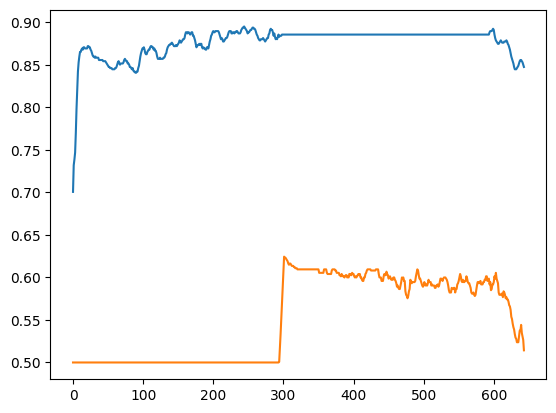

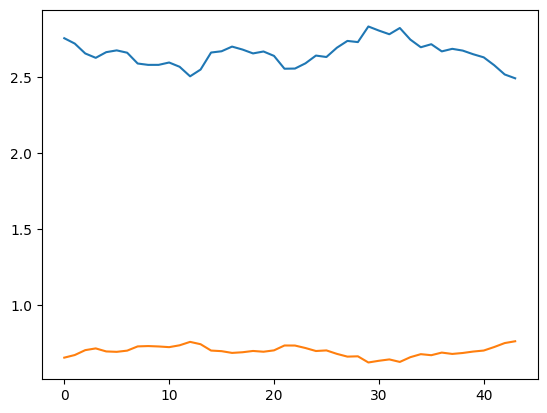

50 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5904762148857117
credit loss: 2.6385990142822267
gender loss: 0.692426323890686
51 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5333333611488342
credit loss: 2.663673210144043
gender loss: 0.6939669847488403
52 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.523809552192688
credit loss: 2.605300712585449
gender loss: 0.7065755724906921
53 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5904762148857117
credit loss: 2.3440296173095705
gender loss: 0.84844970703125
54 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5428571701049805
credit loss: 2.6123067855834963
gender loss: 0.7030038833618164
55 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5523809790611267
credit loss: 2.6753257751464843
gender loss: 0.6778577566146851
56 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.561904788017273
credit loss: 2.6231250762939453
gender loss: 0.71

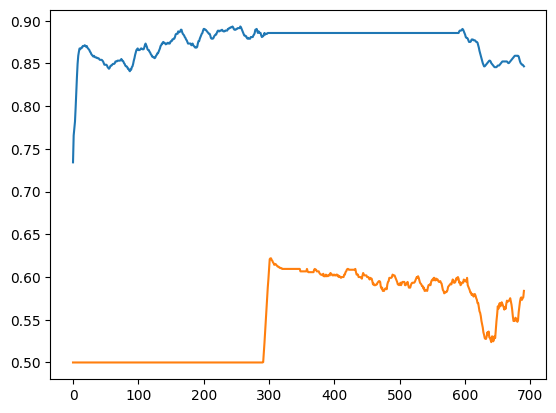

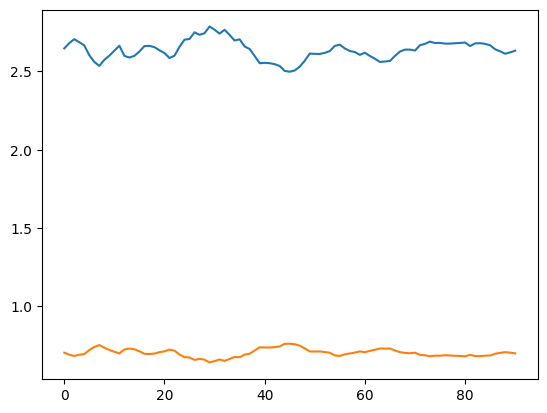

100 / 1200
credit accuracy: 0.8571428656578064
gender accuracy: 0.561904788017273
credit loss: 2.696247100830078
gender loss: 0.6696425676345825
101 / 1200
credit accuracy: 0.8571428656578064
gender accuracy: 0.5714285969734192
credit loss: 2.7509050369262695
gender loss: 0.6745651364326477
102 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.5714285969734192
credit loss: 2.5765790939331055
gender loss: 0.7177944183349609
103 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.561904788017273
credit loss: 2.568973350524902
gender loss: 0.730587363243103
104 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.5714285969734192
credit loss: 2.5974435806274414
gender loss: 0.7090104818344116
105 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.5523809790611267
credit loss: 2.570016098022461
gender loss: 0.730603039264679
106 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5904762148857117
credit loss: 2.709423828125
gender loss: 0

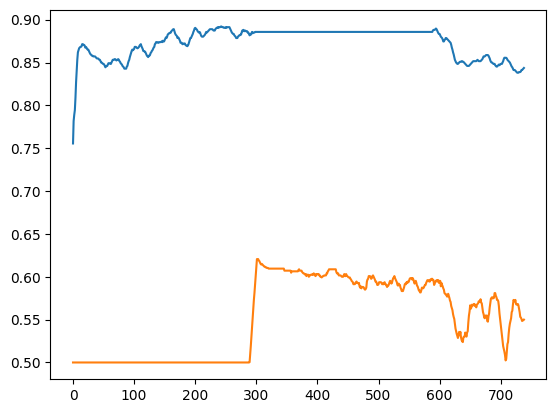

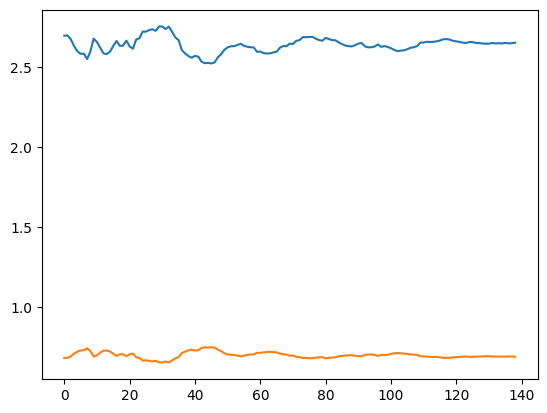

150 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.5714285969734192
credit loss: 2.6772533416748048
gender loss: 0.6770907044410706
151 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.523809552192688
credit loss: 2.552277755737305
gender loss: 0.7275754809379578
152 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5142857432365417
credit loss: 2.5131086349487304
gender loss: 0.7533511519432068
153 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5714285969734192
credit loss: 2.6750120162963866
gender loss: 0.6899769902229309
154 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5714285969734192
credit loss: 2.651361274719238
gender loss: 0.6875497698783875
155 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5714285969734192
credit loss: 2.6439935684204103
gender loss: 0.6902696490287781
156 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.561904788017273
credit loss: 2.6750581741333006
gender 

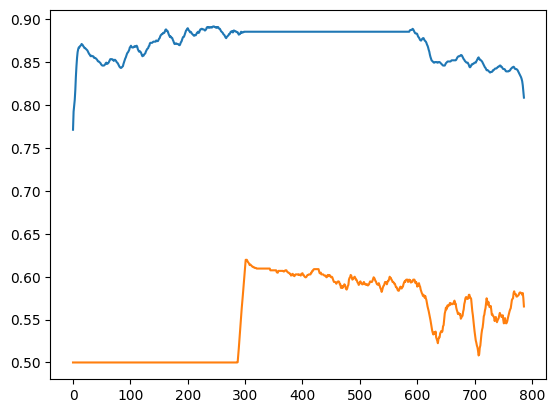

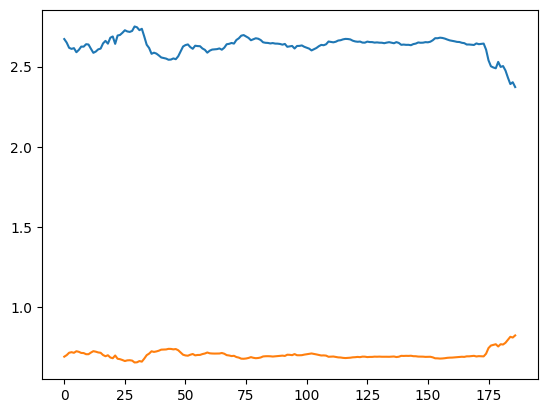

200 / 1200
credit accuracy: 0.723809540271759
gender accuracy: 0.5142857432365417
credit loss: 2.258260726928711
gender loss: 0.8575776219367981
201 / 1200
credit accuracy: 0.7142857313156128
gender accuracy: 0.5714285969734192
credit loss: 2.493727684020996
gender loss: 0.7521422505378723
202 / 1200
credit accuracy: 0.723809540271759
gender accuracy: 0.5428571701049805
credit loss: 2.6287086486816404
gender loss: 0.717452883720398
203 / 1200
credit accuracy: 0.7142857313156128
gender accuracy: 0.5523809790611267
credit loss: 2.922443962097168
gender loss: 0.5849567651748657
204 / 1200
credit accuracy: 0.7142857313156128
gender accuracy: 0.5523809790611267
credit loss: 2.47839469909668
gender loss: 0.771504282951355
205 / 1200
credit accuracy: 0.7142857313156128
gender accuracy: 0.5809524059295654
credit loss: 2.909676361083984
gender loss: 0.600542426109314
206 / 1200
credit accuracy: 0.7142857313156128
gender accuracy: 0.523809552192688
credit loss: 2.6549072265625
gender loss: 0.698

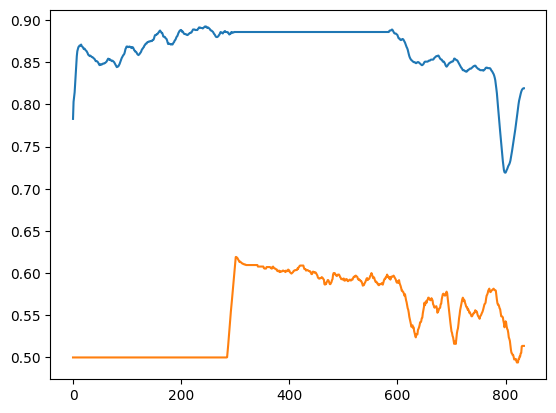

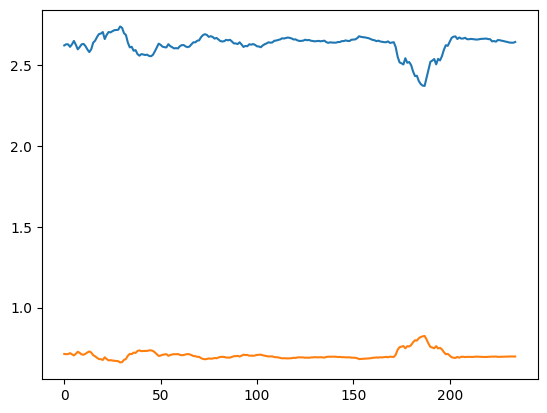

250 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.4952380955219269
credit loss: 2.6405147552490233
gender loss: 0.6916611194610596
251 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.4952380955219269
credit loss: 2.667527198791504
gender loss: 0.6925414204597473
252 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.6095238327980042
credit loss: 2.62137508392334
gender loss: 0.6993314027786255
253 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5142857432365417
credit loss: 2.6238378524780273
gender loss: 0.6983407735824585
254 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5333333611488342
credit loss: 2.6353307723999024
gender loss: 0.6944488286972046
255 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.523809552192688
credit loss: 2.614540672302246
gender loss: 0.7021070718765259
256 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5523809790611267
credit loss: 2.627894973754883
gender lo

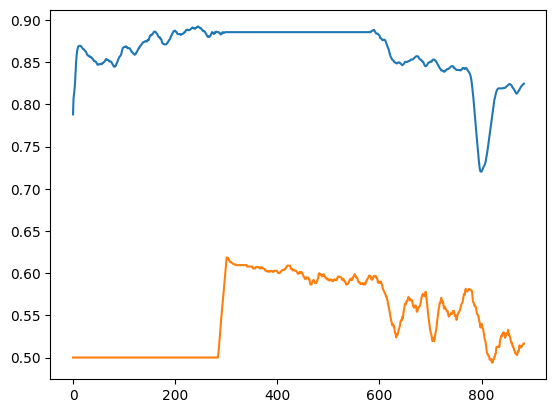

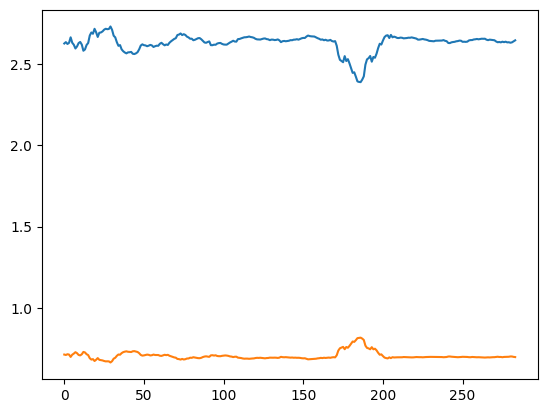

300 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5047619342803955
credit loss: 2.4641714096069336
gender loss: 0.7779071927070618
301 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5428571701049805
credit loss: 3.285914993286133
gender loss: 0.4623126983642578
302 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.43809524178504944
credit loss: 2.6379314422607423
gender loss: 0.6926921606063843
303 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.4952380955219269
credit loss: 2.6356533050537108
gender loss: 0.7057678699493408
304 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.4952380955219269
credit loss: 2.6101348876953123
gender loss: 0.703865647315979
305 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.4952380955219269
credit loss: 2.6481243133544923
gender loss: 0.7145314812660217
306 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5047619342803955
credit loss: 2.637619209289551
gende

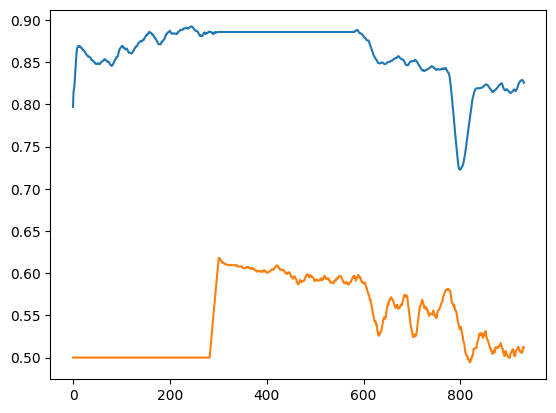

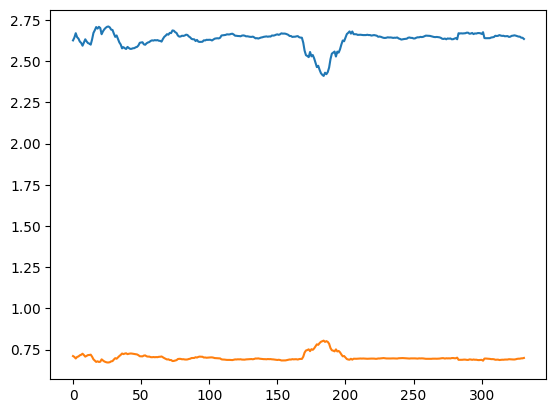

350 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5428571701049805
credit loss: 2.66403865814209
gender loss: 0.6943694949150085
351 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5333333611488342
credit loss: 2.649088478088379
gender loss: 0.6921181082725525
352 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.523809552192688
credit loss: 2.630063056945801
gender loss: 0.6962539553642273
353 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5428571701049805
credit loss: 2.6493505477905273
gender loss: 0.6881347894668579
354 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.4952380955219269
credit loss: 2.655905342102051
gender loss: 0.6907828450202942
355 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.523809552192688
credit loss: 2.610096740722656
gender loss: 0.7042073011398315
356 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.523809552192688
credit loss: 2.685135078430176
gender loss: 

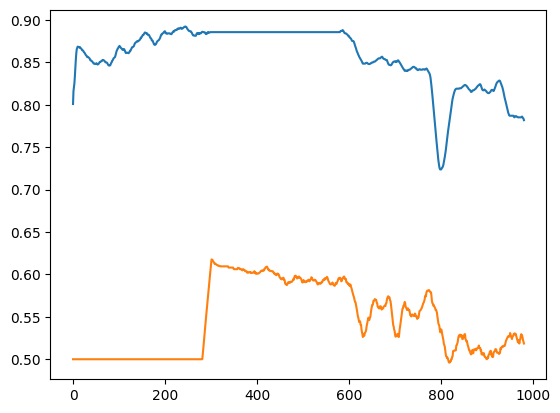

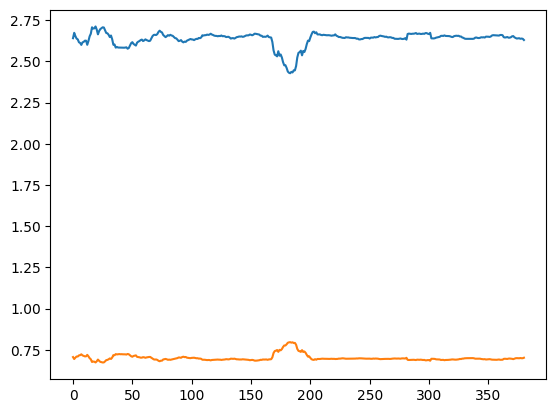

400 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4476190507411957
credit loss: 2.816468048095703
gender loss: 0.6238346099853516
401 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.4952380955219269
credit loss: 2.494108200073242
gender loss: 0.7519127726554871
402 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.4952380955219269
credit loss: 2.6675603866577147
gender loss: 0.6934480667114258
403 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.4952380955219269
credit loss: 2.6299360275268553
gender loss: 0.6960417032241821
404 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.641265869140625
gender loss: 0.6913588643074036
405 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.6040443420410155
gender loss: 0.706613302230835
406 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.561904788017273
credit loss: 2.6772438049316407
gender loss:

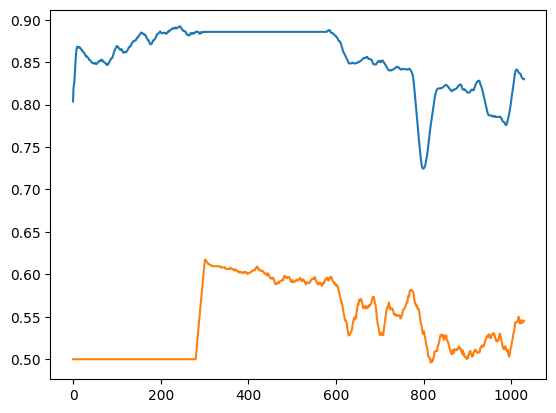

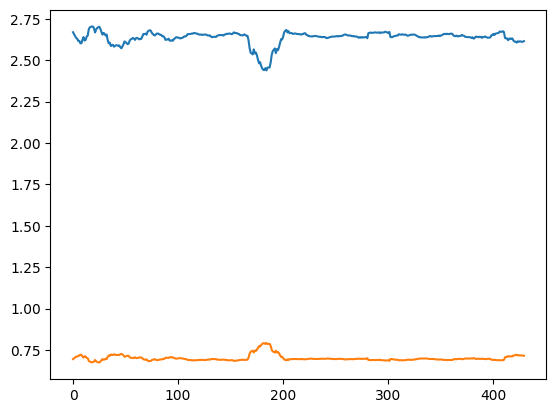

450 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.5523809790611267
credit loss: 2.6726184844970704
gender loss: 0.6915627717971802
451 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.4952380955219269
credit loss: 2.6772897720336912
gender loss: 0.6892315745353699
452 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5809524059295654
credit loss: 2.6597801208496095
gender loss: 0.6844780445098877
453 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.6000000238418579
credit loss: 2.777842903137207
gender loss: 0.6497921943664551
454 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5142857432365417
credit loss: 2.7250253677368166
gender loss: 0.6836215257644653
455 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5428571701049805
credit loss: 2.6987403869628905
gender loss: 0.6805638074874878
456 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.5047619342803955
credit loss: 2.629377555847168
gende

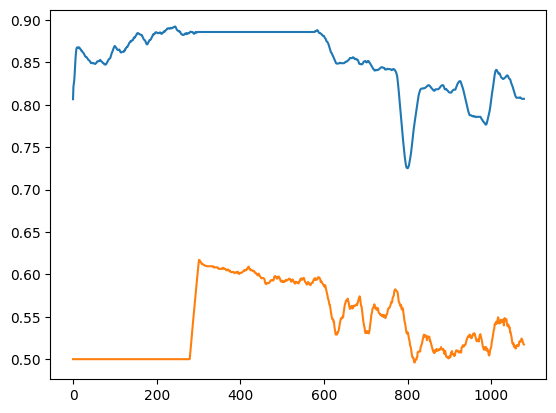

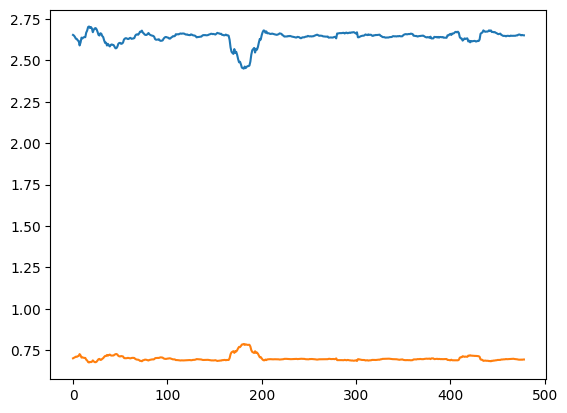

500 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5047619342803955
credit loss: 2.609201431274414
gender loss: 0.7043380737304688
501 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5047619342803955
credit loss: 2.6998804092407225
gender loss: 0.6682263016700745
502 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5047619342803955
credit loss: 2.6864585876464844
gender loss: 0.7002733945846558
503 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.4952380955219269
credit loss: 2.5582019805908205
gender loss: 0.725273609161377
504 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.46666666865348816
credit loss: 2.689932441711426
gender loss: 0.6830541491508484
505 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5428571701049805
credit loss: 2.860432815551758
gender loss: 0.6186429262161255
506 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.43809524178504944
credit loss: 2.950424003601074
gender los

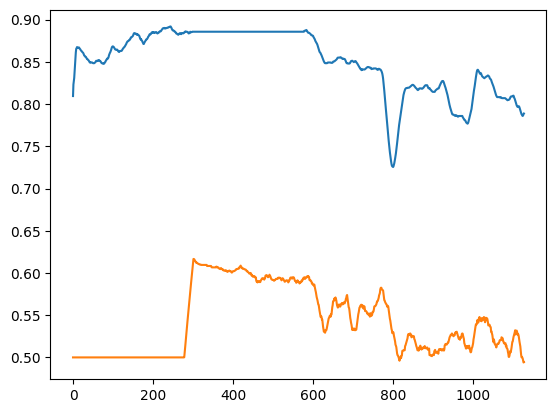

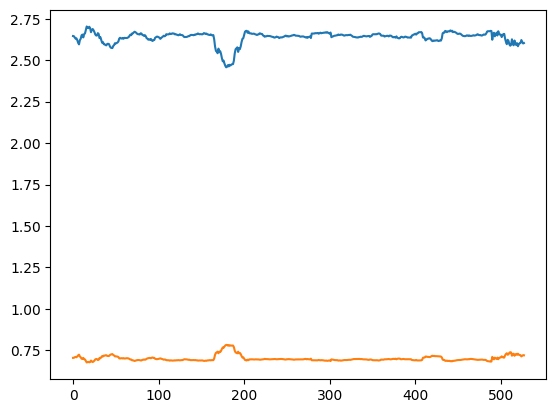

550 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5523809790611267
credit loss: 2.649590492248535
gender loss: 0.7001647353172302
551 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5428571701049805
credit loss: 2.5938652038574217
gender loss: 0.7228671312332153
552 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5047619342803955
credit loss: 2.629657173156738
gender loss: 0.6988083124160767
553 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5333333611488342
credit loss: 2.6630861282348635
gender loss: 0.6952050924301147
554 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.4000000059604645
credit loss: 2.60792236328125
gender loss: 0.7258244752883911
555 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5333333611488342
credit loss: 2.6394075393676757
gender loss: 0.7155898213386536
556 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5523809790611267
credit loss: 2.576962471008301
gender los

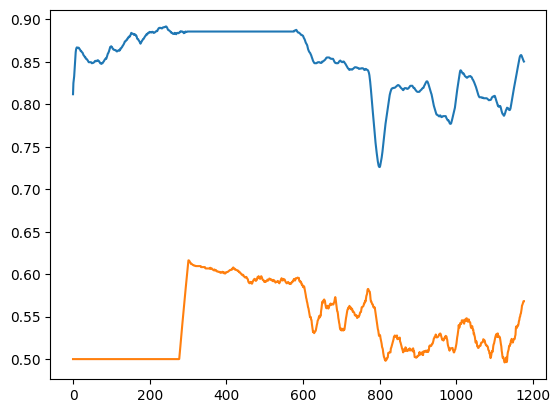

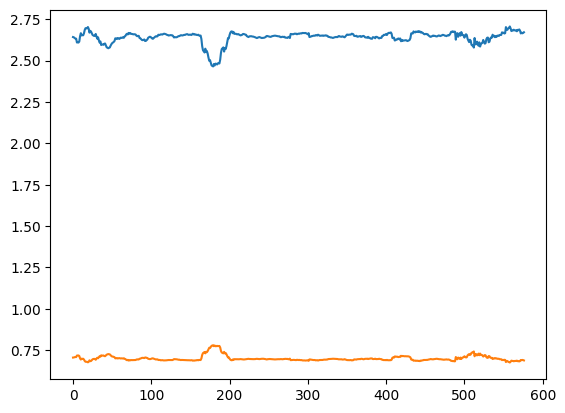

600 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.561904788017273
credit loss: 2.513127326965332
gender loss: 0.7525028586387634
601 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5714285969734192
credit loss: 2.6527307510375975
gender loss: 0.686914324760437
602 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5523809790611267
credit loss: 2.696495246887207
gender loss: 0.6810222864151001
603 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.561904788017273
credit loss: 2.5017906188964845
gender loss: 0.7620056867599487
604 / 1200
credit accuracy: 0.8571428656578064
gender accuracy: 0.5714285969734192
credit loss: 2.759369468688965
gender loss: 0.6458942890167236
605 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.5809524059295654
credit loss: 2.3427923202514647
gender loss: 0.8194841146469116
606 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.5714285969734192
credit loss: 2.6680679321289062
gender lo

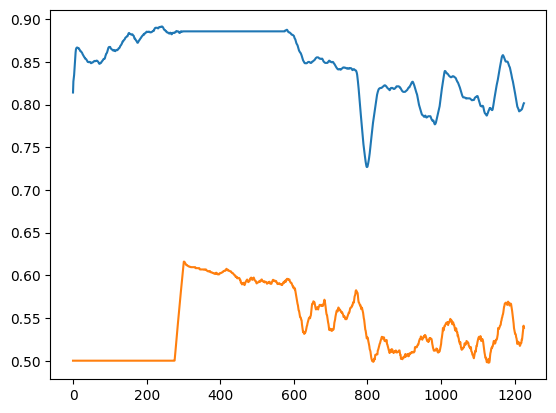

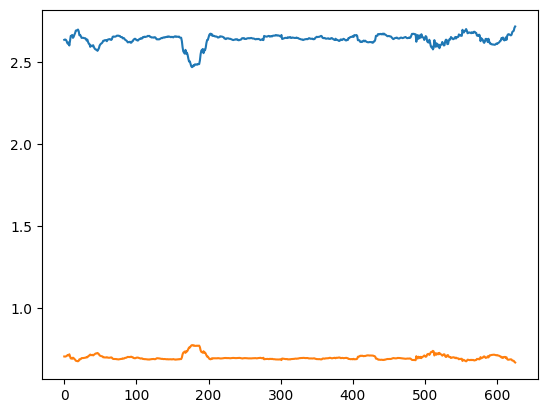

650 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.43809524178504944
credit loss: 2.815092849731445
gender loss: 0.6242538690567017
651 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.4285714328289032
credit loss: 2.830466461181641
gender loss: 0.6362260580062866
652 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.5047619342803955
credit loss: 2.6482921600341798
gender loss: 0.701146125793457
653 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.4000000059604645
credit loss: 2.687070846557617
gender loss: 0.673236072063446
654 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.5047619342803955
credit loss: 2.706980895996094
gender loss: 0.6850772500038147
655 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.5047619342803955
credit loss: 2.695886993408203
gender loss: 0.681096613407135
656 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.5333333611488342
credit loss: 2.650163269042969
gender loss

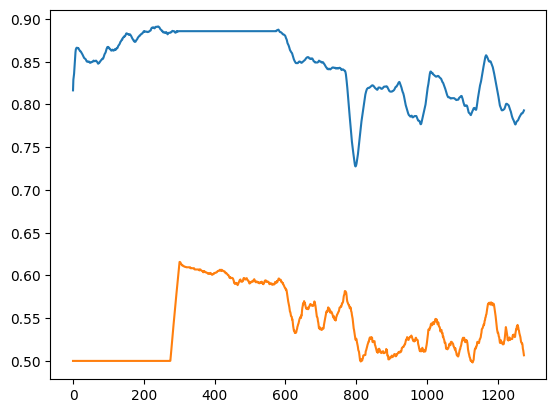

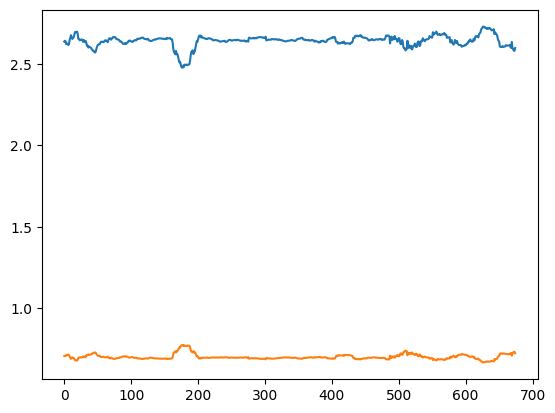

700 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.4952380955219269
credit loss: 2.6002187728881836
gender loss: 0.7078829407691956
701 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.4952380955219269
credit loss: 2.6619440078735352
gender loss: 0.6950844526290894
702 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.4952380955219269
credit loss: 2.5914073944091798
gender loss: 0.7114690542221069
703 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5047619342803955
credit loss: 3.1111591339111326
gender loss: 0.5369919538497925
704 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.4952380955219269
credit loss: 2.3441787719726563
gender loss: 0.8224676847457886
705 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5047619342803955
credit loss: 2.521635055541992
gender loss: 0.7472508549690247
706 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5809524059295654
credit loss: 2.7843704223632812
gende

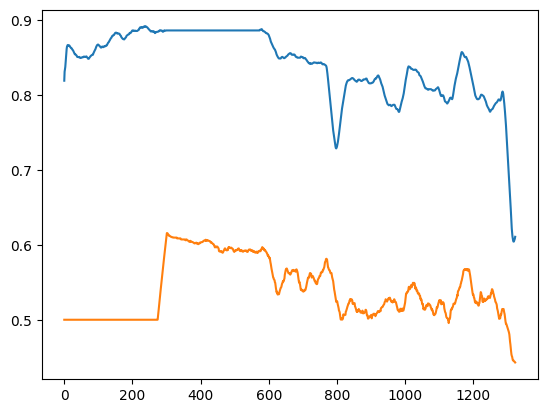

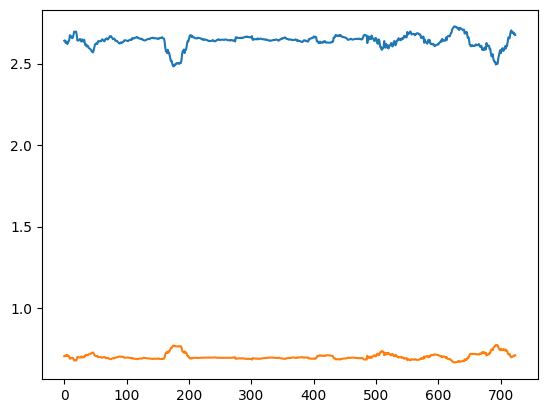

750 / 1200
credit accuracy: 0.7333333492279053
gender accuracy: 0.43809524178504944
credit loss: 2.1231990814208985
gender loss: 0.9391075372695923
751 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4476190507411957
credit loss: 2.8446018218994142
gender loss: 0.6762086153030396
752 / 1200
credit accuracy: 0.7523809671401978
gender accuracy: 0.4000000059604645
credit loss: 2.563360404968262
gender loss: 0.7466942667961121
753 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.4000000059604645
credit loss: 2.359979438781738
gender loss: 0.8240131139755249
754 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.380952388048172
credit loss: 2.6250062942504884
gender loss: 0.697945773601532
755 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.4952380955219269
credit loss: 2.6315118789672853
gender loss: 0.7074884176254272
756 / 1200
credit accuracy: 0.8476190567016602
gender accuracy: 0.4952380955219269
credit loss: 2.1428552627563477
gender 

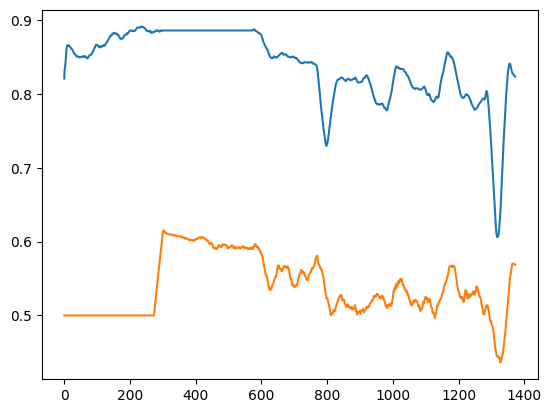

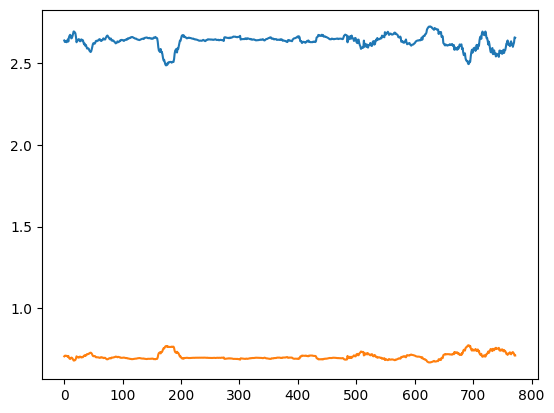

800 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.561904788017273
credit loss: 2.565774345397949
gender loss: 0.7345104217529297
801 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5523809790611267
credit loss: 2.4692365646362306
gender loss: 0.7719606161117554
802 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5523809790611267
credit loss: 2.4456083297729494
gender loss: 0.8022201657295227
803 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.561904788017273
credit loss: 2.6576406478881838
gender loss: 0.6959214210510254
804 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.561904788017273
credit loss: 2.434493637084961
gender loss: 0.7775333523750305
805 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5714285969734192
credit loss: 2.907431411743164
gender loss: 0.601158857345581
806 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.5714285969734192
credit loss: 2.3962274551391602
gender los

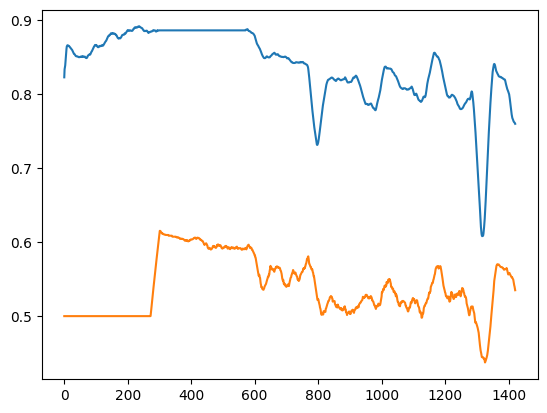

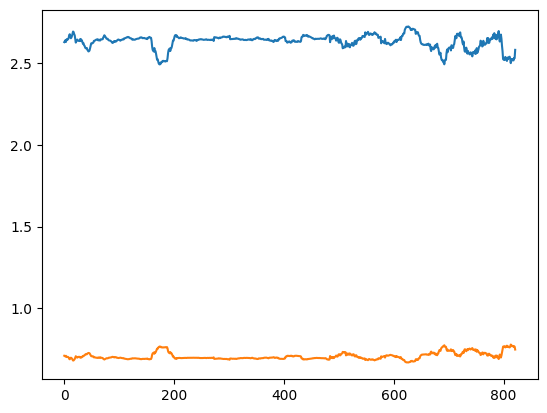

850 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 1.812703514099121
gender loss: 1.1132615804672241
851 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.5870136260986327
gender loss: 0.7132619023323059
852 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.173149299621582
gender loss: 0.913260281085968
853 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.171748733520508
gender loss: 0.9132610559463501
854 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 1.7792192459106446
gender loss: 1.1132609844207764
855 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.6171302795410156
gender loss: 0.7132617235183716
856 / 1200
credit accuracy: 0.761904776096344
gender accuracy: 0.4952380955219269
credit loss: 2.1699203491210937
gender loss: 0

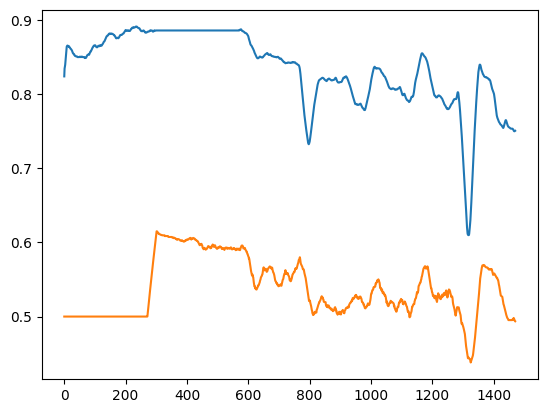

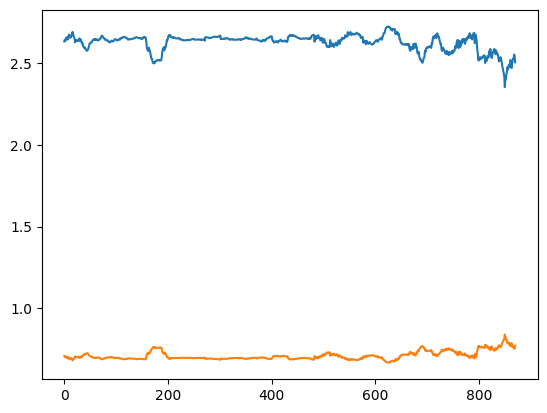

900 / 1200
credit accuracy: 0.7428571581840515
gender accuracy: 0.48571428656578064
credit loss: 2.430314064025879
gender loss: 0.7910054922103882
901 / 1200
credit accuracy: 0.7428571581840515
gender accuracy: 0.5142857432365417
credit loss: 2.9068721771240233
gender loss: 0.6014214754104614
902 / 1200
credit accuracy: 0.7333333492279053
gender accuracy: 0.5333333611488342
credit loss: 2.7120616912841795
gender loss: 0.6753643751144409
903 / 1200
credit accuracy: 0.7428571581840515
gender accuracy: 0.5333333611488342
credit loss: 1.8452041625976563
gender loss: 1.1132619380950928
904 / 1200
credit accuracy: 0.7523809671401978
gender accuracy: 0.5333333611488342
credit loss: 2.859146308898926
gender loss: 0.6188711524009705
905 / 1200
credit accuracy: 0.7523809671401978
gender accuracy: 0.5333333611488342
credit loss: 2.4895914077758787
gender loss: 0.7706655859947205
906 / 1200
credit accuracy: 0.723809540271759
gender accuracy: 0.523809552192688
credit loss: 3.2819580078125
gender lo

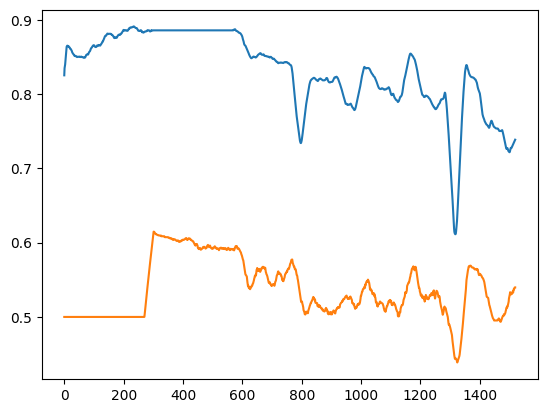

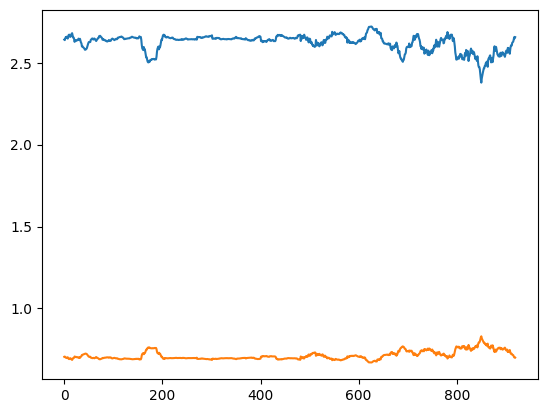

950 / 1200
credit accuracy: 0.7333333492279053
gender accuracy: 0.5428571701049805
credit loss: 2.3389007568359377
gender loss: 0.8248011469841003
951 / 1200
credit accuracy: 0.7333333492279053
gender accuracy: 0.523809552192688
credit loss: 2.781085205078125
gender loss: 0.6414051651954651
952 / 1200
credit accuracy: 0.7428571581840515
gender accuracy: 0.523809552192688
credit loss: 2.4237239837646483
gender loss: 0.8192867040634155
953 / 1200
credit accuracy: 0.7523809671401978
gender accuracy: 0.5523809790611267
credit loss: 2.7381826400756837
gender loss: 0.6966301798820496
954 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.523809552192688
credit loss: 2.6877666473388673
gender loss: 0.6866105198860168
955 / 1200
credit accuracy: 0.7809523940086365
gender accuracy: 0.6000000238418579
credit loss: 2.6629953384399414
gender loss: 0.7020534873008728
956 / 1200
credit accuracy: 0.7714285850524902
gender accuracy: 0.561904788017273
credit loss: 2.5796062469482424
gender l

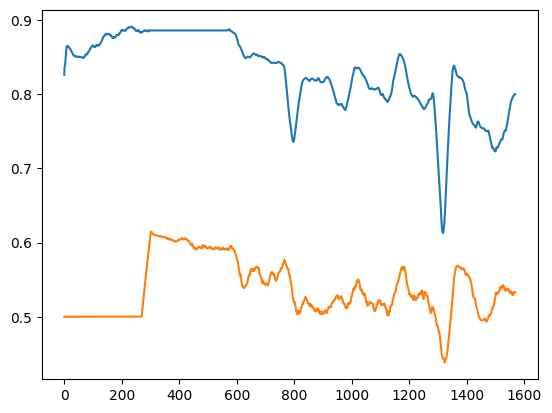

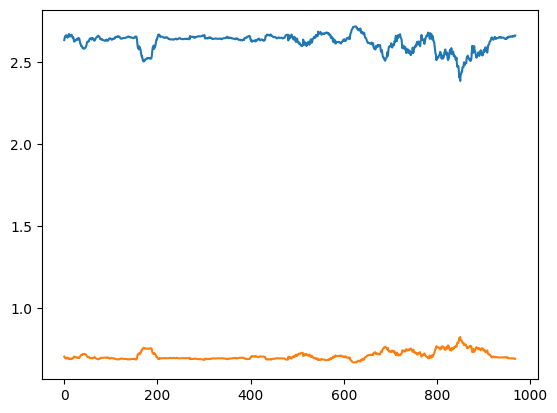

1000 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5047619342803955
credit loss: 2.706572723388672
gender loss: 0.6683256030082703
1001 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5047619342803955
credit loss: 2.6558576583862306
gender loss: 0.7021006941795349
1002 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.523809552192688
credit loss: 2.649833106994629
gender loss: 0.7078652381896973
1003 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.5523809790611267
credit loss: 2.6855825424194335
gender loss: 0.679911732673645
1004 / 1200
credit accuracy: 0.800000011920929
gender accuracy: 0.48571428656578064
credit loss: 2.6703636169433596
gender loss: 0.6886061429977417
1005 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.5428571701049805
credit loss: 2.6884679794311523
gender loss: 0.6875234842300415
1006 / 1200
credit accuracy: 0.7904762029647827
gender accuracy: 0.523809552192688
credit loss: 2.6705360412597656
gende

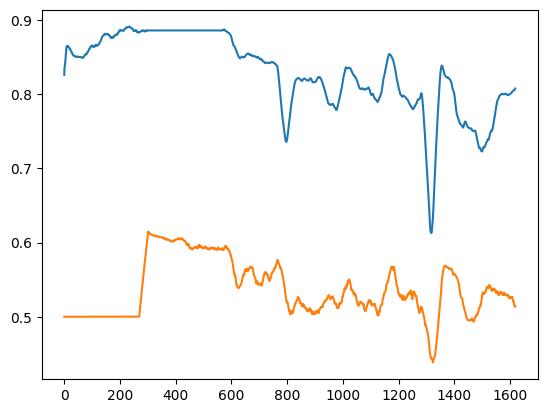

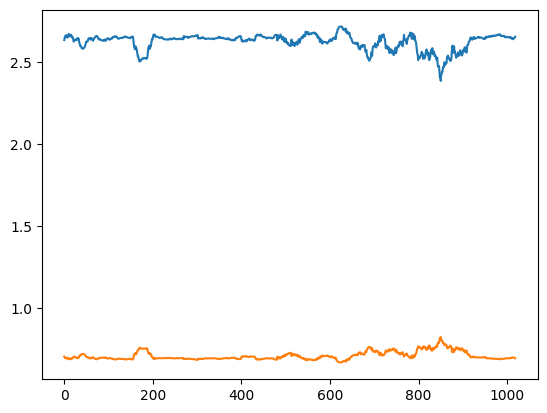

1050 / 1200
credit accuracy: 0.8095238208770752
gender accuracy: 0.5047619342803955
credit loss: 2.663784980773926
gender loss: 0.6861022710800171
1051 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.46666666865348816
credit loss: 2.625950241088867
gender loss: 0.7012313604354858
1052 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5333333611488342
credit loss: 2.63726749420166
gender loss: 0.695946216583252
1053 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.523809552192688
credit loss: 2.6323814392089844
gender loss: 0.6975279450416565
1054 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.5142857432365417
credit loss: 2.5991752624511717
gender loss: 0.7089870572090149
1055 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.46666666865348816
credit loss: 2.5809656143188477
gender loss: 0.7157296538352966
1056 / 1200
credit accuracy: 0.8190476298332214
gender accuracy: 0.4761904776096344
credit loss: 2.693177604675293
g

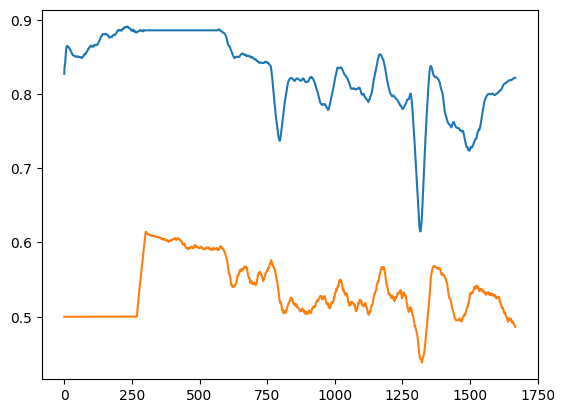

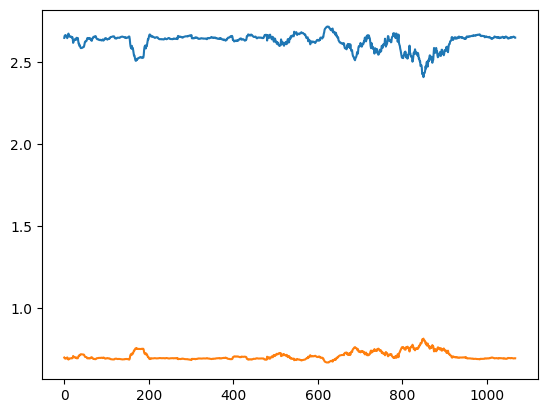

1100 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.4571428596973419
credit loss: 2.6211479187011717
gender loss: 0.7005192637443542
1101 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.46666666865348816
credit loss: 2.618669891357422
gender loss: 0.7014303803443909
1102 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.4571428596973419
credit loss: 2.610763359069824
gender loss: 0.7036932706832886
1103 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.5142857432365417
credit loss: 2.7150253295898437
gender loss: 0.6844860315322876
1104 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.523809552192688
credit loss: 2.65945987701416
gender loss: 0.6848074197769165
1105 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.46666666865348816
credit loss: 2.670322799682617
gender loss: 0.68059241771698
1106 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.4285714328289032
credit loss: 2.5144315719604493
ge

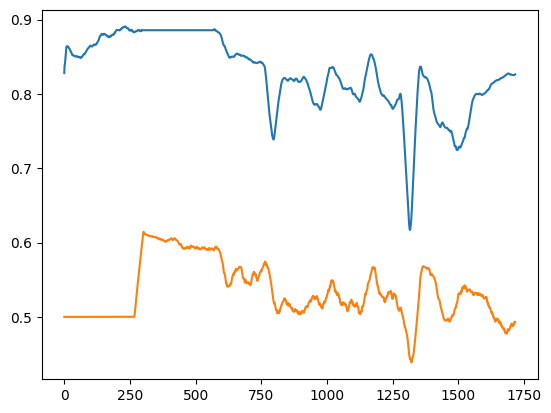

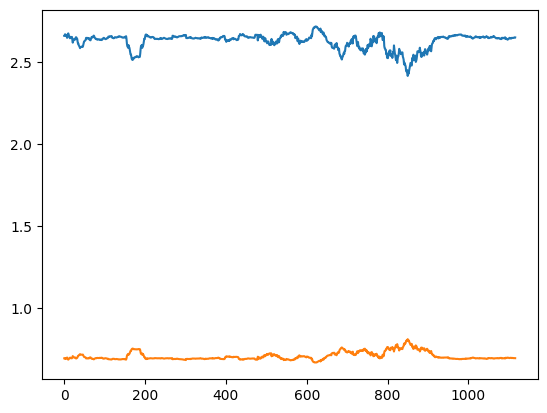

1150 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.4952380955219269
credit loss: 2.6466802597045898
gender loss: 0.6995552182197571
1151 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.5333333611488342
credit loss: 2.60581111907959
gender loss: 0.7057982683181763
1152 / 1200
credit accuracy: 0.8380952477455139
gender accuracy: 0.48571428656578064
credit loss: 2.7158266067504884
gender loss: 0.6859054565429688
1153 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.4952380955219269
credit loss: 2.679779815673828
gender loss: 0.7002571821212769
1154 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.46666666865348816
credit loss: 2.662047576904297
gender loss: 0.6907070875167847
1155 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.5047619342803955
credit loss: 2.6599262237548826
gender loss: 0.6961064338684082
1156 / 1200
credit accuracy: 0.8285714387893677
gender accuracy: 0.4761904776096344
credit loss: 2.611935997009277

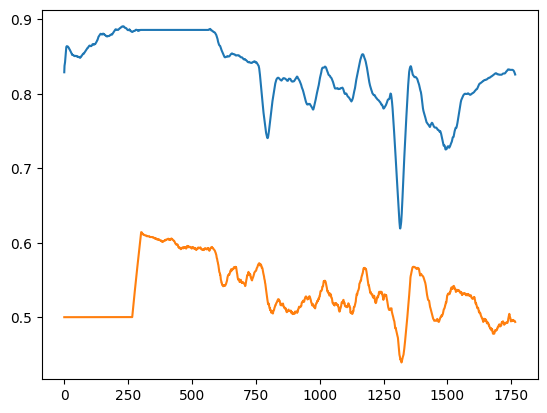

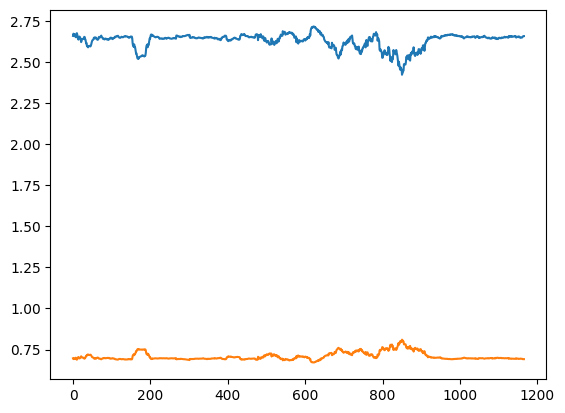

In [15]:
epochs = 1200

model_credit = torch.load("best_model_credit.pt")
model_gender = torch.load("best_model_gender.pt")
criterion_credit = torch.nn.CrossEntropyLoss()
criterion_gender = torch.nn.CrossEntropyLoss()
optimizer_credit = torch.optim.Adam(model_credit.parameters(),lr = 0.002, weight_decay=1e-5)
optimizer_gender = torch.optim.Adam(model_gender.parameters(),lr = 0.01, weight_decay=1e-5)
print(len(gender_accuracy))
print(len(credit_accuracy))
gender_accuracy2 = [0.5]*len(credit_accuracy)+gender_accuracy
credit_accuracy2 = credit_accuracy+[credit_accuracy[-1]]*len(gender_accuracy)

print(len(gender_accuracy2))
print(len(credit_accuracy2))

credit_accuracy, gender_accuracy, model_credit, model_gender =train_and_validation_2(model_credit=model_credit,
                     model_gender=model_gender,
                     train_loader=test_loader,
                     val_loader=val_loader,
                     criterion_credit=criterion_credit,
                     criterion_gender=criterion_gender,
                     optimizer_credit=optimizer_credit,
                     optimizer_gender=optimizer_gender,
                     epochs=epochs,
                     grad_clip=50,
                     gender_accuracy=gender_accuracy2,
                     credit_accuracy=credit_accuracy2,
                     )

In [16]:
"""
epochs = 1000

model_credit = torch.load("best_model_credit.pt")
model_gender = torch.load("best_model_gender.pt")
criterion_credit = Custom_ANN_approved_loss()
criterion_gender = torch.nn.CrossEntropyLoss()#Custom_ANN_loss()
optimizer_credit = torch.optim.Adam(model_credit.parameters(),lr = 0.005)
optimizer_gender = torch.optim.Adam(model_gender.parameters(),lr = 0.005)
print(len(gender_accuracy))
print(len(credit_accuracy))
gender_accuracy2 = [0.5]*len(credit_accuracy)+gender_accuracy
credit_accuracy2 = credit_accuracy+[credit_accuracy[-1]]*len(gender_accuracy)

print(len(gender_accuracy2))
print(len(credit_accuracy2))

credit_accuracy, gender_accuracy, model_credit, model_gender =train_and_validation(model_credit=model_credit,
                     model_gender=model_gender,
                     train_loader=train_loader,
                     val_loader=val_loader,
                     criterion_credit=criterion_credit,
                     criterion_gender=criterion_gender,
                     optimizer_credit=optimizer_credit,
                     optimizer_gender=optimizer_gender,
                     epochs=epochs,
                     grad_clip=50,
                     gender_accuracy=gender_accuracy2,
                     credit_accuracy=credit_accuracy2,
                     )
"""

'\nepochs = 1000\n\nmodel_credit = torch.load("best_model_credit.pt")\nmodel_gender = torch.load("best_model_gender.pt")\ncriterion_credit = Custom_ANN_approved_loss()\ncriterion_gender = torch.nn.CrossEntropyLoss()#Custom_ANN_loss()\noptimizer_credit = torch.optim.Adam(model_credit.parameters(),lr = 0.005)\noptimizer_gender = torch.optim.Adam(model_gender.parameters(),lr = 0.005)\nprint(len(gender_accuracy))\nprint(len(credit_accuracy))\ngender_accuracy2 = [0.5]*len(credit_accuracy)+gender_accuracy\ncredit_accuracy2 = credit_accuracy+[credit_accuracy[-1]]*len(gender_accuracy)\n\nprint(len(gender_accuracy2))\nprint(len(credit_accuracy2))\n\ncredit_accuracy, gender_accuracy, model_credit, model_gender =train_and_validation(model_credit=model_credit,\n                     model_gender=model_gender,\n                     train_loader=train_loader,\n                     val_loader=val_loader,\n                     criterion_credit=criterion_credit,\n                     criterion_gender=cr

In [17]:
epochs = 400
criterion_gender = torch.nn.CrossEntropyLoss()
optimizer_gender = torch.optim.Adam(model_gender.parameters(),lr = 0.007, weight_decay=1e-5)

best_model_gender, ga = train_gender(model_credit=model_credit,model_gender=model_gender,train_loader=test_loader,val_loader=val_loader,criterion=criterion_gender,optimizer=optimizer_gender,epochs=epochs)


savemat("accuracy.mat",{"credit":credit_accuracy+[credit_accuracy[-1]]*len(ga),"gender":gender_accuracy+ga})

0 / 400
0.1394580880800883
gender accuracy: 0.4761904776096344
P(not random): 0.3137154885393165
1 / 400
0.1395230423836481
gender accuracy: 0.4476190507411957
P(not random): 0.1426422109328288
2 / 400
0.14010645662035262
gender accuracy: 0.43809524178504944
P(not random): 0.10324910367985451
3 / 400
0.14379407337733677
gender accuracy: 0.4571428596973419
P(not random): 0.19106290526460956
4 / 400
0.1452075305439177
gender accuracy: 0.4285714328289032
P(not random): 0.07239116966502468
5 / 400
0.14073129892349243
gender accuracy: 0.4285714328289032
P(not random): 0.07239116966502468
6 / 400
0.14013359376362391
gender accuracy: 0.43809524178504944
P(not random): 0.10324910367985451
7 / 400
0.14001191230047316
gender accuracy: 0.4285714328289032
P(not random): 0.07239116966502468
8 / 400
0.13925044877188547
gender accuracy: 0.41904762387275696
P(not random): 0.04912125221121855
9 / 400
0.13876469021751767
gender accuracy: 0.48571428656578064
P(not random): 0.38545949546855673
10 / 400
0.

In [25]:
def test_model(model_credit,model_gender,test_loader):
    gcm = [[0,0],[0,0]]
    ccm = [[0,0],[0,0]]

    for batch_nr, (features,label_credit,label_gender) in enumerate(test_loader):
            # Run models
            predictions_credit, last_features = model_credit(features)
            predictions_gender = model_gender(last_features)


            pc = torch.argmax(predictions_credit,dim=1).tolist()
            pg = torch.argmax(predictions_gender,dim=1).tolist()
            lc = torch.argmax(label_credit,dim=1).tolist()
            lg = torch.argmax(label_gender,dim=1).tolist()

            for i in range(len(pc)):
                  gcm[pg[i]][lg[i]] += 1
                  ccm[pc[i]][lc[i]] += 1
    return gcm,ccm


            





            
            

In [27]:
gcm, ccm = test_model(model_credit=model_credit,model_gender=model_gender,test_loader=test_loader)
print(gcm)
print(ccm)

[[7, 1], [6, 7]]
[[10, 4], [2, 5]]
